In this competition it is not only important to predict the landmark for an image but also to make sure that if an image is not a landmark that we don't make a prediction.
Correctly identifying non-landmark images in the test set will increase the score of a submission. 
Removing as much of the non-landmark images from the training set will decrease the total amount of images that we need to train on and it will improve the 'correctness' of the model if it is trained on the landmark images and not on all the selfies, hotel-rooms and beds etcetera that were made near the landmark.

A good way to start the identification is to use the Places365 dataset and models as described on this [webpage](http://places2.csail.mit.edu/). I've created a small dataset of 50 images selected from the 4+ million in the trainset to show how it could be done. In the Places365 dataset there 365 classes and each class is also marked as either 'indoor' or 'outdoor'. We could interpret this also as 'non-landmark' or 'landmark'. It could be further optimized offcourse...an image of the inside of a castle will be marked as 'indoor' but will very likely be a legitimate 'landmark'.

Just by using the default 'indoor/outdoor' marker and determining it for both train and test data I was able to improve my best model so far with about 0.015 - 0.02 score on the leaderboard. 

In [1]:
import os
import numpy as np
import pandas as pd 
from PIL import Image
from cv2 import resize
import matplotlib.pyplot as plt
print(os.listdir("../input"))

['google-landmark-2019-samples', 'keras-vgg16-places365', 'landmark-recognition-2019']


I've found a very nice repository on Github where the trained models were already converted to Keras models. See this [webpage](https://github.com/GKalliatakis/Keras-VGG16-places365) for the original sources. Since I had issues using the 'git clone' command I've put the code into a Kaggle Dataset. Let's import the necessary modules from this dataset.

In [2]:
# VGG 16 Places 365 scripts in custom dataset
os.chdir("/kaggle/input/keras-vgg16-places365/")
from vgg16_places_365 import VGG16_Places365
os.chdir("/kaggle/working/")

Using TensorFlow backend.


Lets get the list of all image samples and resize them to the format that we will also use to predict with the model later on.
Note that I just resize the images as-is. Very likely that creating multiple crops (or any other pre-processing step) for an image could lead to a better average prediction of landmark or non-landmark

In [3]:
# Get List of Images
image_samples = '../input/google-landmark-2019-samples/'
all_images = os.listdir(image_samples)

# Resize all images
all_images_resized = []
for filename in all_images:    
    im = np.array(Image.open(image_samples + filename).resize((224, 224), Image.LANCZOS))    
    all_images_resized.append(im)

To show the sample images...

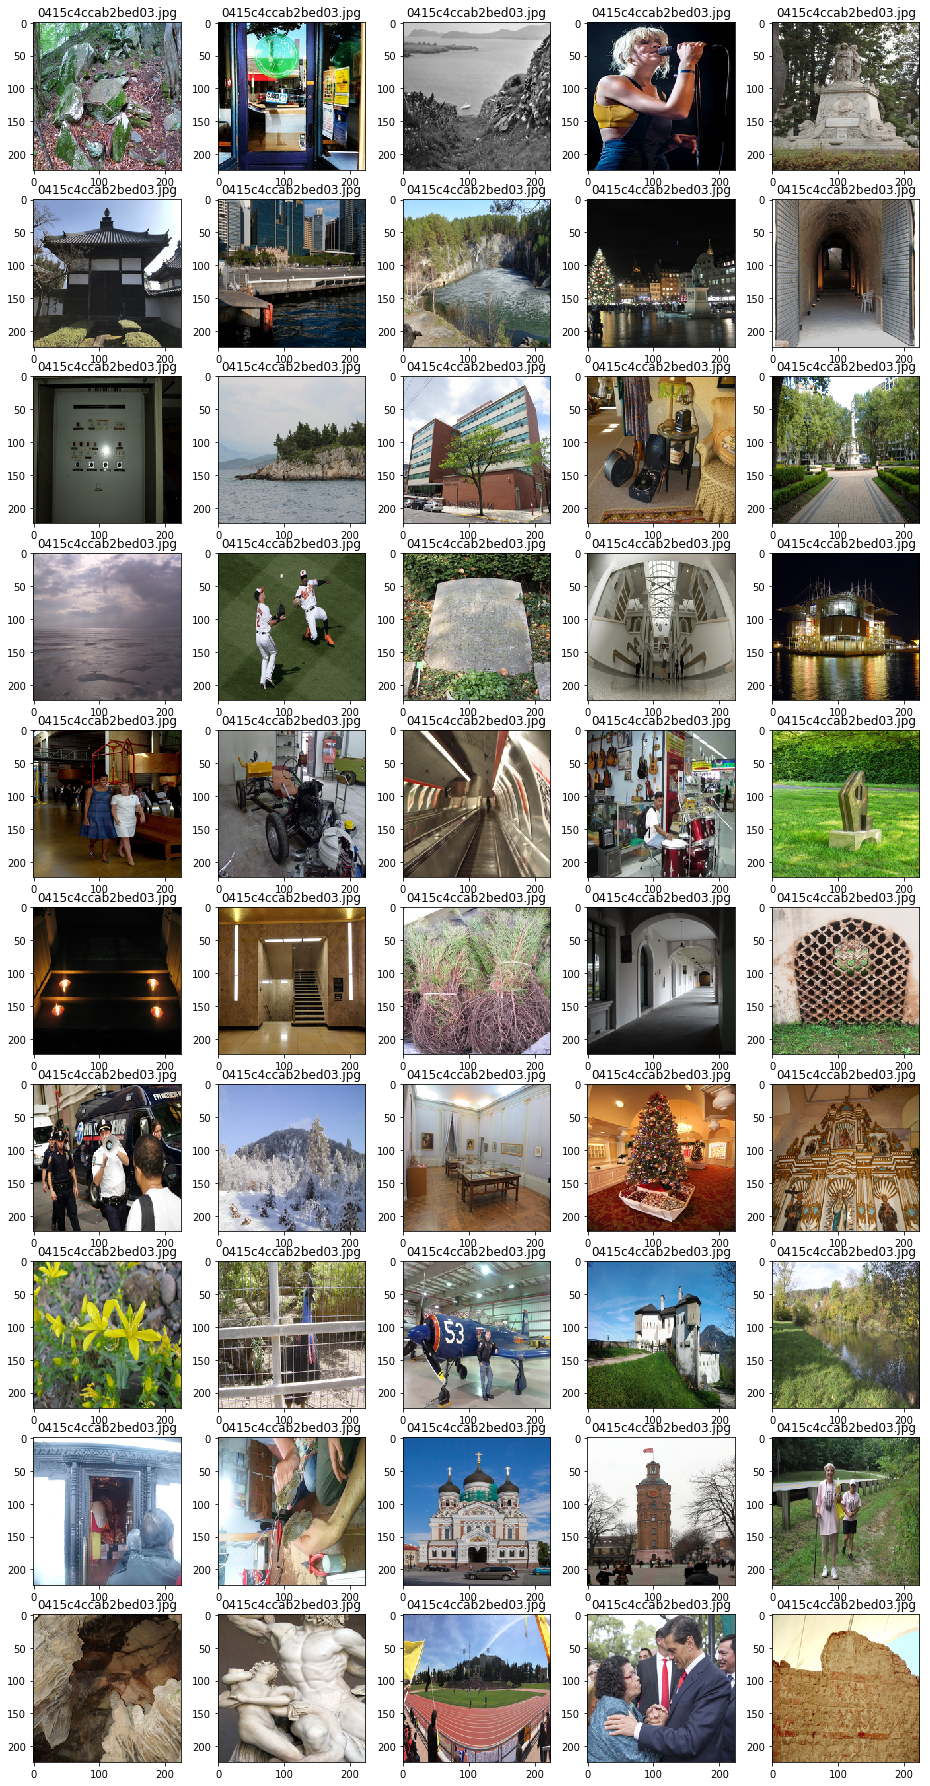

In [4]:
# Plot image examples
fig = plt.figure(figsize = (16, 32))
for index, im in zip(range(1, len(all_images_resized)+1), all_images_resized):
    fig.add_subplot(10, 5, index)
    plt.title(filename)
    plt.imshow(im)   

First we will now create the model and make a Top-3 of class predictions for each of the images.

In [5]:
# Placeholders for predictions
p0, p1, p2 = [], [], []

# Places365 Model
model = VGG16_Places365(weights='places')
topn = 5

# Loop through all images
for image in all_images_resized:
    
    # Predict Top N Image Classes
    image = np.expand_dims(image, 0)
    topn_preds = np.argsort(model.predict(image)[0])[::-1][0:topn]

    p0.append(topn_preds[0])
    p1.append(topn_preds[1])
    p2.append(topn_preds[2])

# Create dataframe for later usage
topn_df = pd.DataFrame()
topn_df['filename'] = np.array(all_images)
topn_df['p0'] = np.array(p0)
topn_df['p1'] = np.array(p1)
topn_df['p2'] = np.array(p2)
topn_df.to_csv('topn_class_numbers.csv', index = False)

# Summary
topn_df.head()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
543088640/543085444 [==============================] - 59s 0us/step


filename   p0   p1   p2
0  03e35f1005b209b2.jpg  150  141  233
1  03d8128c66cc96f6.jpg  332  301  262
2  0415a574a2289499.jpg  187  163  190
3  0415db26b3a2cd04.jpg  236   93   19
4  0081bb6f9955f00e.jpg  226   86   69

Now that we have our Top-3 class predictions for each image we can get the name of each class and the 'indoor' or 'outdoor' marker. I've modified the default files and created the 'categories_places365_extended.csv' file which includes the 'indoor(1)/outdoor(2)' label as specified in this [file](https://github.com/CSAILVision/places365/blob/master/IO_places365.txt).

As stated earlier we will use the default 'indoor' label to mark images as 'non-landmark' and 'outdoor' as 'landmark'.

In [6]:
# Read Class number, class name and class indoor/outdoor marker
class_information = pd.read_csv('../input/keras-vgg16-places365/categories_places365_extended.csv')
class_information.head()

# Set Class Labels
for col in ['p0', 'p1', 'p2']:
    topn_df[col + '_label'] = topn_df[col].map(class_information.set_index('class')['label'])
    topn_df[col + '_landmark'] = topn_df[col].map(class_information.set_index('class')['io'].replace({1:'non-landmark', 2:'landmark'}))
topn_df.to_csv('topn_all_info.csv', index = False)

# Summary
topn_df.head()   


filename   p0      ...                p2_label   p2_landmark
0  03e35f1005b209b2.jpg  150      ...        /m/mountain_path      landmark
1  03d8128c66cc96f6.jpg  332      ...             /p/pharmacy  non-landmark
2  0415a574a2289499.jpg  187      ...              /i/iceberg      landmark
3  0415db26b3a2cd04.jpg  236      ...          /a/art_gallery  non-landmark
4  0081bb6f9955f00e.jpg  226      ...       /b/burial_chamber  non-landmark

[5 rows x 10 columns]

Let's see which images are now predicted as 'landmark' based on only 'p0_landmark'.

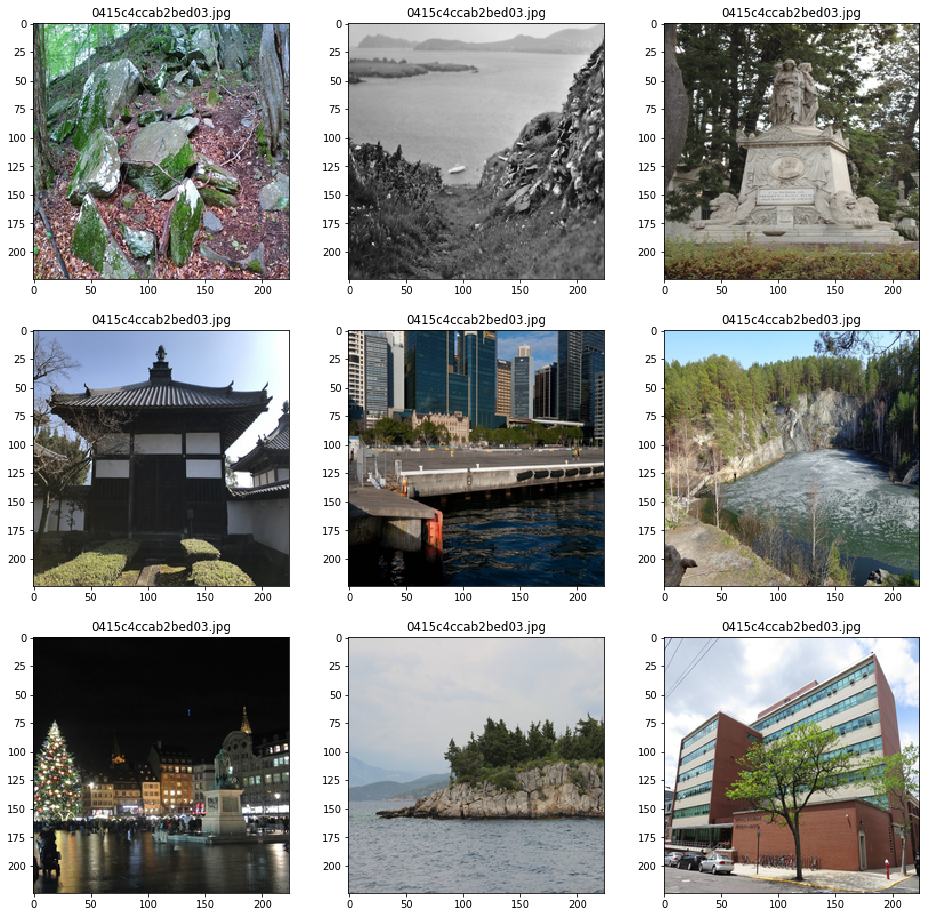

In [7]:
# Get 'landmark' images
n = 9
landmark_images =  topn_df[topn_df['p0_landmark'] == 'landmark']['filename']
landmark_indexes = landmark_images[:n].index.values

# Plot image examples
fig = plt.figure(figsize = (16, 16))
for index, im in zip(range(1, n+1), [ all_images_resized[i] for i in landmark_indexes]):
    fig.add_subplot(3, 3, index)
    plt.title(filename)
    plt.imshow(im)

Now the same for images that are predicted as 'non-landmark' based on only 'p0_landmark'.

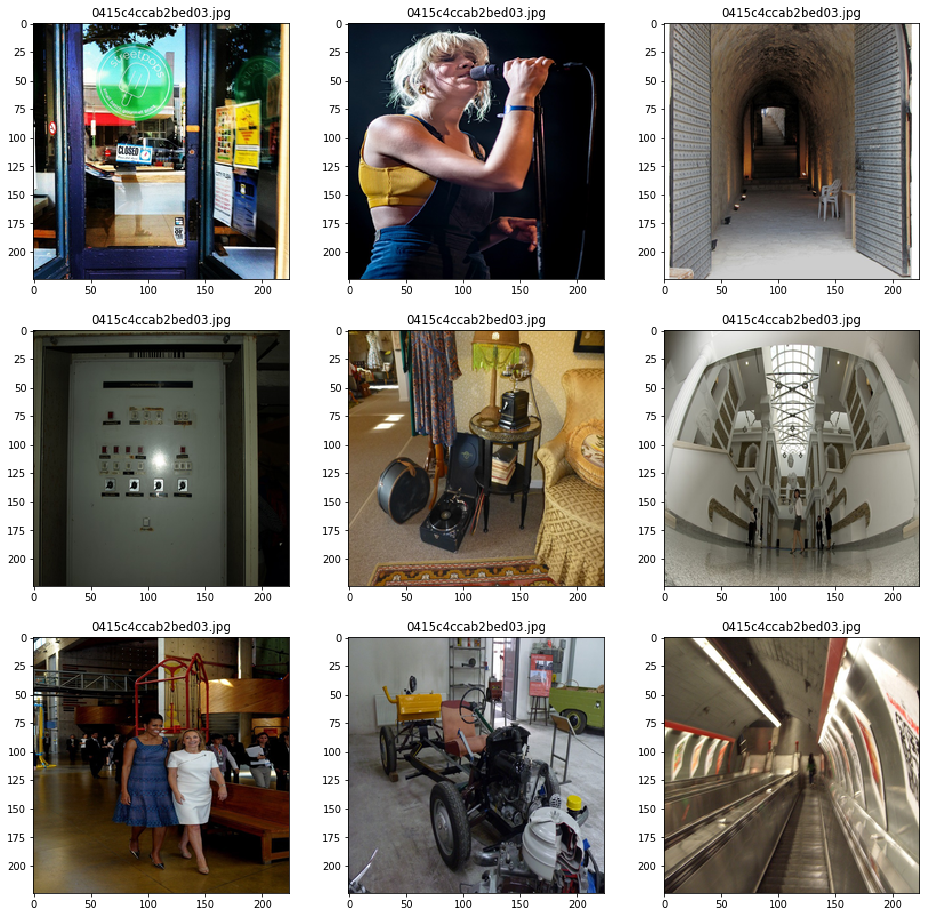

In [8]:
# Get 'non-landmark' images
n = 9
landmark_images =  topn_df[topn_df['p0_landmark'] == 'non-landmark']['filename']
landmark_indexes = landmark_images[:n].index.values

# Plot image examples
fig = plt.figure(figsize = (16, 16))
for index, im in zip(range(1, n+1), [ all_images_resized[i] for i in landmark_indexes]):
    fig.add_subplot(3, 3, index)
    plt.title(filename)
    plt.imshow(im)

That for sure looks promising! The majority of predicted 'non-landmarks' for sure look like they are indeed not landmarks.

**Summary**

So we looked at a very usable way to predict which images are landmarks or not.
Some ideas/notes from my side when you start using the code.
1. Think about the image-preprocessing.. a simple resize, multiple-crops, augmentation etc.
2. How to use the predictions? Will you use the Top-N in a majority vote or with probability above a certain threshold?
3. Take into account the time needed to predict over 4+ million images...

I hope you enjoyed this notebook and please let me know if you have any questions or remarks.
And enjoy the competition.